In [3]:
#SigKernel Trial 2
import apache_beam

In [23]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt

In [4]:
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'

In [5]:
forecasts = xr.open_zarr(forecast_path)
observations = xr.open_zarr(obs_path)

In [6]:
forecasts

<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [57]:
forecastssel = forecasts['temperature'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
forecasts0 = forecastssel[:,:,:,:,:]
savedfor = forecasts0.values

observationsel = observations['temperature'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) #Plus 15 days
savedobs = observationsel.values

#Geopotential is about 50,000 doesn't work
#Temperature in Kelvin is about 250, doesn't work
#Specific Humidity is about 0.001
# u component of wind 10 to 0.01, doesn't work


In [58]:
savedfor

array([[[[[238.6304 , 240.68762, 241.64917, ..., 235.49094, 232.31192,
           231.68085],
          [238.3748 , 240.08365, 240.18507, ..., 235.33163, 232.59259,
           232.09094],
          [237.95708, 239.8857 , 239.02975, ..., 235.37729, 232.86913,
           232.31616],
          ...,
          [239.49394, 242.19656, 242.53186, ..., 234.11076, 230.65495,
           230.30624],
          [239.37457, 242.0054 , 243.2416 , ..., 234.97269, 231.3703 ,
           230.72989],
          [238.9898 , 241.5363 , 242.96219, ..., 235.4919 , 231.97208,
           231.20317]],

         [[238.65195, 240.98102, 241.22441, ..., 235.74503, 232.0968 ,
           230.54672],
          [238.40746, 240.2516 , 240.17351, ..., 235.53119, 232.20996,
           231.00201],
          [238.17238, 239.66528, 239.02544, ..., 235.17366, 232.34746,
           231.4425 ],
          ...,
          [239.01549, 242.10527, 242.14047, ..., 234.6574 , 230.41281,
           229.15341],
          [239.05644, 241.91

In [ ]:
kernelscores = []
#Non weighted
#61 predictlags, just doing 60
#Can't sum observations beforehand (well can but would have to split it into either the 0-12 or 6-18 paths)


maxvalue = np.array([savedobs.max(),savedfor.max()]).max()
savedobsshift = savedobs #/(20*maxvalue)
savedforshift = savedfor #/(20*maxvalue)

#print(maxvalue)
#print(savedobsshift.shape)
static_kernel = sigkernel.RBFKernel(sigma=1)
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

#think about removing culmative
for i in range(60):
        fors = savedforshift[:,:,i,:,:]
        obs = savedobsshift[i:i-60,:,:][::2,:,:]

        obs = obs.reshape(-1,64*32)
        obs = np.cumsum(obs,axis=0)

        fors = fors.reshape(20,50,64*32)
        fors = np.cumsum(fors,axis=0)

        obs = np.expand_dims(obs, axis = 0)
        fors = np.transpose(fors, (1,0,2)) #some 

        X = torch.tensor(fors, dtype=torch.double)
        #sigkernel.transform(X)
        y = torch.tensor(obs, dtype=torch.double)

        val = signature_kernel.compute_scoring_rule(X,y).item()
        print(val)
        kernelscores.append(val)


-1.0000000000003801
-1.0000000000003801
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0000000000003801
-0.9999999999996199
-1.0
-1.0
-0.9999999999996199
-1.0000000000003801
-0.9999999999992397
-1.0
-0.9999999999996199
-0.9999999999992397
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0000000000003801
-0.9999999999996199
-0.9999999999996199
-1.0
-1.0000000000003801
-0.9999999999996199
-0.9999999999996199
-0.9999999999996199
-1.0000000000003801
-0.9999999999996199
-0.9999999999996199
-1.0000000000003801
-1.0
-0.9999999999996199
-1.0
-0.9999999999996199
-1.0
-1.0
-1.0000000000003801
-1.0
-1.0000000000003801
-1.0
-0.9999999999996199
-1.0000000000003801
-1.0000000000003801
-1.0
-1.0000000000003801
-0.9999999999996199
-1.0
-1.0000000000003801
-1.0
-1.0000000000003801
-1.0000000000007603
-1.0
-1.0


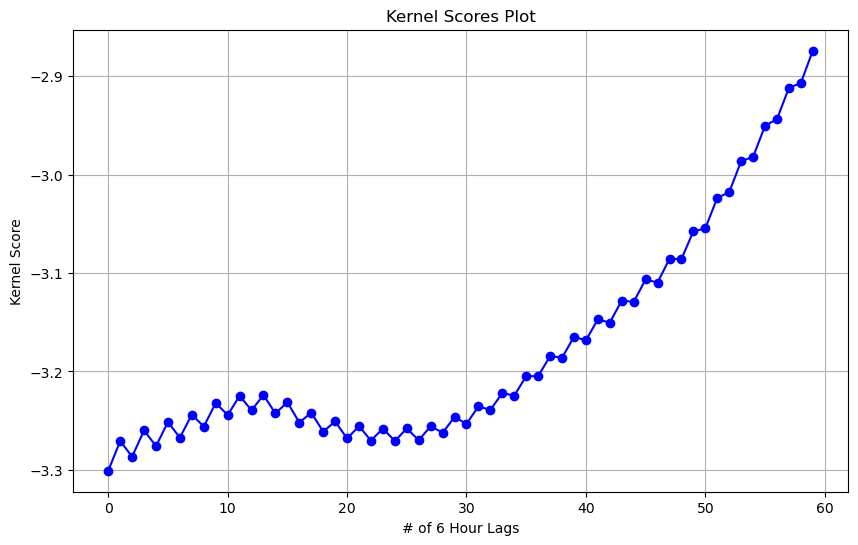

In [ ]:
kernelscoresspechumidity = kernelscores
#Sigma 1, Dyadic Order 2, CumSum, Not Lead Lagged, No shift, Not Lat weighted

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(kernelscoresspechumidity, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [34]:
y_obs = np.array([[[2],[2],[3]]]) #Needa 1 Dim, 3 timesteps, 1 output per timestep
x_for = np.array([[[2],[100],[3]],[[2],[2],[3]],[[2],[2],[3]]]) #2 Models, each with 3 timesteps, and 1 output per timestep

llx_for = sigkernel.transform(x_for, scale = 2, ll = True)

In [36]:
llx_for.shape

(3, 5, 2)

In [35]:
x_for.shape

(3, 3, 1)

In [105]:
savedobsshift = savedobs 
savedforshift = savedfor 

fors = savedforshift[:,:,0,:,:]
obs = savedobsshift[0:0-60,:,:][::2,:,:]

obs = obs.reshape(-1,64*32)
obs = np.cumsum(obs,axis=0)

fors = fors.reshape(20,50,64*32)
fors = np.cumsum(fors,axis=0)

obs = np.expand_dims(obs, axis = 0)
fors = np.transpose(fors, (1,0,2)) #some 

llobs = sigkernel.transform(obs, scale = 1, at = True, ll = True)
llfors = sigkernel.transform(fors, scale = 1, at = True, ll = True)

X = torch.tensor(llfors, dtype=torch.double)
y = torch.tensor(llobs, dtype=torch.double)

print(X.shape)
print(y.shape)

torch.Size([50, 39, 4097])
torch.Size([1, 39, 4097])


In [60]:
X.shape
#50 batches, 20 Timesteps, length 2048

torch.Size([389, 36])
#389 paths of 36 timesteps ,1 
#LeadLag + Add Time dimension sent to

torch.Size([389, 71, 3])
#389 paths, time is n*2 -1 longer after leadlagged, with each path having time, lead,lag

torch.Size([389, 71, 3])

In [61]:
X.shape
#50,20,2048
#50 paths, of 20 timesteps, 2048
#
#Need to think



torch.Size([50, 20, 2048])

In [87]:
import iisignature

In [91]:
path = X
print(path.shape)
signature = iisignature.sig(path[0,:,:],1)
print(signature.shape)

torch.Size([50, 20, 2048])
(2048,)


In [85]:
print(X)

tensor([[[ 238.6304,  240.6876,  241.6492,  ...,  235.4919,  231.9721,
           231.2032],
         [ 477.2362,  481.6865,  482.4923,  ...,  472.0268,  463.5526,
           460.9557],
         [ 715.5092,  723.0223,  723.2234,  ...,  709.1782,  697.2852,
           691.4649],
         ...,
         [4289.0742, 4329.7104, 4337.1143,  ..., 4312.7700, 4251.7744,
          4208.3613],
         [4528.3647, 4571.2183, 4580.0073,  ..., 4550.4736, 4488.1177,
          4443.6377],
         [4768.4297, 4814.2573, 4823.4175,  ..., 4784.4810, 4722.7075,
          4678.8608]],

        [[ 238.5398,  240.6725,  241.6891,  ...,  235.7596,  231.8762,
           231.4021],
         [ 476.9137,  481.8163,  482.6769,  ...,  471.7059,  463.6749,
           461.3353],
         [ 715.2103,  723.2255,  723.5005,  ...,  708.4861,  696.9437,
           691.6628],
         ...,
         [4288.6875, 4329.9917, 4338.1636,  ..., 4312.7295, 4251.8267,
          4208.9507],
         [4527.6924, 4571.0376, 4580.848

In [102]:
shifted = sigkernel.transform(fors, scale = 1, at = True, ll = True)
shifted

array([[[0.00000000e+00, 2.38630402e+02, 2.40687622e+02, ...,
         2.35491898e+02, 2.31972076e+02, 2.31203171e+02],
        [2.63157895e-02, 2.38630402e+02, 2.40687622e+02, ...,
         4.72026794e+02, 4.63552612e+02, 4.60955719e+02],
        [5.26315789e-02, 4.77236206e+02, 4.81686523e+02, ...,
         4.72026794e+02, 4.63552612e+02, 4.60955719e+02],
        ...,
        [9.47368421e-01, 4.52836475e+03, 4.57121826e+03, ...,
         4.55047363e+03, 4.48811768e+03, 4.44363770e+03],
        [9.73684211e-01, 4.52836475e+03, 4.57121826e+03, ...,
         4.78448096e+03, 4.72270752e+03, 4.67886084e+03],
        [1.00000000e+00, 4.76842969e+03, 4.81425732e+03, ...,
         4.78448096e+03, 4.72270752e+03, 4.67886084e+03]],

       [[0.00000000e+00, 2.38539795e+02, 2.40672531e+02, ...,
         2.35759567e+02, 2.31876205e+02, 2.31402069e+02],
        [2.63157895e-02, 2.38539795e+02, 2.40672531e+02, ...,
         4.71705872e+02, 4.63674927e+02, 4.61335266e+02],
        [5.26315789e-02, 

In [99]:
shifted.shape

(50, 39, 4097)

In [84]:
print(shifted[0,0,:])
print(shifted[0,1,:])

[  0.         238.63040161 240.68762207 ... 235.49189758 231.97207642
 231.20317078]
[2.63157895e-02 2.38630402e+02 2.40687622e+02 ... 4.72026794e+02
 4.63552612e+02 4.60955719e+02]


In [97]:
print(shifted)

[[[0.00000000e+00 2.38630402e+02 2.40687622e+02 ... 2.35491898e+02
   2.31972076e+02 2.31203171e+02]
  [2.63157895e-02 2.38630402e+02 2.40687622e+02 ... 4.72026794e+02
   4.63552612e+02 4.60955719e+02]
  [5.26315789e-02 4.77236206e+02 4.81686523e+02 ... 4.72026794e+02
   4.63552612e+02 4.60955719e+02]
  ...
  [9.47368421e-01 4.52836475e+03 4.57121826e+03 ... 4.55047363e+03
   4.48811768e+03 4.44363770e+03]
  [9.73684211e-01 4.52836475e+03 4.57121826e+03 ... 4.78448096e+03
   4.72270752e+03 4.67886084e+03]
  [1.00000000e+00 4.76842969e+03 4.81425732e+03 ... 4.78448096e+03
   4.72270752e+03 4.67886084e+03]]

 [[0.00000000e+00 2.38539795e+02 2.40672531e+02 ... 2.35759567e+02
   2.31876205e+02 2.31402069e+02]
  [2.63157895e-02 2.38539795e+02 2.40672531e+02 ... 4.71705872e+02
   4.63674927e+02 4.61335266e+02]
  [5.26315789e-02 4.76913696e+02 4.81816284e+02 ... 4.71705872e+02
   4.63674927e+02 4.61335266e+02]
  ...
  [9.47368421e-01 4.52769238e+03 4.57103760e+03 ... 4.55045020e+03
   4.48833